# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def fmt_items(lines,max_lines=0):
    max_width=max([len(line)for line in lines])
    empty =' '*max_width
    lines = [line.ljust(max_width)for line in lines]
    lines += [empty]*(max_lines - len(lines))
    return lines
    
def pp (*list):
    lines = [ str(item).split('\n') for item in list]
    max_lines=max([len(item)for  item in lines])
    lines = [fmt_items(item,max_lines=max_lines)for item in lines]
    lines_t= np.array(lines).T
    print('\n'.join([' '.join(line) for  line in lines_t]))


In [17]:
%matplotlib nbagg

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

import grads_from_assigment2 as gr2

In [38]:
dir(gr2)

['__builtins__',
 '__cached__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'cross_entropy_loss',
 'l2_regularization',
 'np',
 'softmax_with_cross_entropy',
 'softmx']

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

==GRAD_CHECK== at (0,)  num = 6.000000000039306 anal = 6.0
Gradient check passed!
==GRAD_CHECK== at (0,)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1,)  num = 1.0000000000065512 anal = 1.0
Gradient check passed!
==GRAD_CHECK== at (0, 0)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (0, 1)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1, 0)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1, 1)  num = 1.0000000000065512 anal = 1.0
Gradient check passed!


True

In [6]:
(array_sum(np.array([5.0, 2.0]))[0]-array_sum(np.array([1.0, 2.0]))[0])/4

1.0

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [40]:
import linear_classifer 
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs)
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
print(probs)
# assert np.isclose(probs[0], 1.0)

[2.06106005e-09 4.53978686e-05 9.99954600e-01]
[1. 0. 0.]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [45]:
import linear_classifer
probs = linear_classifer.softmax(np.array([[-5, 0, 5],[-5, 0, 5]]))
    
linear_classifer.cross_entropy_loss(probs, np.array([2,2]))


[0 1] [2 2]
[array([0, 1]), array([2, 2])]
[0.49663118 0.49663118]
log loss =  1.399815248214133


1.399815248214133

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [51]:
probs = linear_classifer.softmax(np.array([[1, 0, 0],[1, 0, 0]]))
linear_classifer.cross_entropy_loss(probs, np.array([0,0]))

[[0.28805844 0.10597078 0.10597078]  [0 0]
 [0.28805844 0.10597078 0.10597078]]      
log loss =  2.489183788983993


2.489183788983993

In [63]:
# TODO Implement combined function orsoftmax and cross entropy and produces gradient #-2.0491237621641485

check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array([1,1])), np.array([[ 1,0,0],[ 1,0,0]], np.float))

[[0.28805844 0.10597078 0.10597078]  [1 1]
 [0.28805844 0.10597078 0.10597078]]      
log loss =  4.4891837889839925
[[0.28806254 0.10597017 0.10597017]  [1 1]
 [0.28805678 0.10597017 0.10597017]]      
log loss =  4.48919531140372
[[0.28805434 0.10597139 0.10597139]  [1 1]
 [0.2880601  0.10597139 0.10597139]]      
log loss =  4.489172266728329
==GRAD_CHECK== at (0, 0)  num = 0.2880584423881061 anal = 0.28805844238291456
[[0.28805783 0.10597267 0.10597055]  [1 1]
 [0.28805783 0.10597055 0.10597055]]      
log loss =  4.489168027853042
[[0.28805905 0.10596888 0.105971  ]  [1 1]
 [0.28805905 0.105971   0.105971  ]]      
log loss =  4.489199550190737
==GRAD_CHECK== at (0, 1)  num = -0.39402922118458855 anal = -0.3940292211914573
[[0.28805783 0.10597055 0.10597267]  [1 1]
 [0.28805783 0.10597055 0.10597055]]      
log loss =  4.489188027853042
[[0.28805905 0.105971   0.10596888]  [1 1]
 [0.28805905 0.105971   0.105971  ]]      
log loss =  4.489179550190737
==GRAD_CHECK== at (0, 2)  num 

True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [64]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
pp('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
pp('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
print('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

predictions = [[ 1.  2. -1.  1.]]
targets =  [[2]]
==GRAD_CHECK== at (0, 0)  num = 0.20603190920009948 anal = 0.20603190919001857
==GRAD_CHECK== at (0, 1)  num = 0.5600527948401712 anal = 0.5600527948339517
==GRAD_CHECK== at (0, 2)  num = -0.9721166132181657 anal = -0.9721166132139888
==GRAD_CHECK== at (0, 3)  num = 0.20603190920009948 anal = 0.20603190919001857
Gradient check passed!
predictions = [[ 2. -1. -1.  1.]
 [ 0.  1.  1.  1.]
 [ 1.  2. -1.  2.]]
targets =  [[3]
 [3]
 [2]]
==GRAD_CHECK== at (0, 0)  num = 0.19515646273449147 anal = 0.19515646271894127
==GRAD_CHECK== at (0, 1)  num = 0.009716268156712005 anal = 0.00971626815181842
==GRAD_CHECK== at (0, 2)  num = 0.009716268156712005 anal = 0.00971626815181842
==GRAD_CHECK== at (0, 3)  num = -0.2615392828864138 anal = -0.2615392828872938
==GRAD_CHECK== at (1, 0)  num = 0.02641155514293558 anal = 0.026411555157523366
==GRAD_CHECK== at (1, 1)  num = 0.07179405047130771 anal = 0.07179405044603954
==GRAD_CHECK== at (1, 2)  num = 0.07

True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [67]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)


loss, dW = linear_classifer.linear_softmax(X, W, target_index)
pp(dW)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

[[0.11245721 0.01521943]  [1 1]
 [0.0413707  0.83095266]]      
log loss =  4.370364905207625
[[-0.11245721  0.48478057] 
 [-0.07108652  0.81573323] 
 [ 0.15382791 -0.15382791]]
[[0.11245721 0.01521943]  [1 1]
 [0.0413707  0.83095266]]      
log loss =  4.370364905207625
[[0.11245522 0.01521946]  [1 1]
 [0.04137079 0.83095453]]      
log loss =  4.370360406959003
[[0.11245921 0.01521939]  [1 1]
 [0.0413706  0.83095079]]      
log loss =  4.370369403536097
==GRAD_CHECK== at (0, 0)  num = -0.11245721367458826 anal = -0.11245721367093255
[[0.11245725 0.01521913]  [1 1]
 [0.04137071 0.83095291]]      
log loss =  4.370384296436465
[[0.11245718 0.01521973]  [1 1]
 [0.04137068 0.83095241]]      
log loss =  4.370345513990775
==GRAD_CHECK== at (0, 1)  num = 0.4847805711305497 anal = 0.48478057113584405
[[0.11245512 0.01521945]  [1 1]
 [0.04137158 0.83095384]]      
log loss =  4.370362061806466
[[0.1124593  0.01521941]  [1 1]
 [0.04136981 0.83095148]]      
log loss =  4.370367748727805
==GRA

True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [70]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

==GRAD_CHECK== at (0, 0)  num = 0.009999999999940612 anal = 0.01
==GRAD_CHECK== at (0, 1)  num = 0.02000000000022817 anal = 0.02
==GRAD_CHECK== at (1, 0)  num = -0.009999999999940612 anal = -0.01
==GRAD_CHECK== at (1, 1)  num = 0.009999999999940612 anal = 0.01
==GRAD_CHECK== at (2, 0)  num = 0.009999999999940612 anal = 0.01
==GRAD_CHECK== at (2, 1)  num = 0.02000000000022817 anal = 0.02
Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [71]:
# TODO: Implement LinearSoftmaxClassifier.fit function 
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)
'''THERE WERE 10 EPOCHS   !!!!!
'''

[[1.10472628e-05 1.11928569e-05 1.10814819e-05 ... 1.11941052e-05 [1 1 4 ... 6 1 3]
  1.10559940e-05 1.12017076e-05]                                                   
 [1.11447689e-05 1.11088786e-05 1.11452252e-05 ... 1.11981071e-05                  
  1.11772235e-05 1.11928690e-05]                                                   
 [1.12110257e-05 1.11679662e-05 1.10519356e-05 ... 1.10281229e-05                  
  1.11195311e-05 1.10262934e-05]                                                   
 ...                                                                               
 [1.10069680e-05 1.10893181e-05 1.12113700e-05 ... 1.10823540e-05                  
  1.11174009e-05 1.10877437e-05]                                                   
 [1.11665450e-05 1.12519947e-05 1.10988008e-05 ... 1.12106571e-05                  
  1.10561953e-05 1.11318301e-05]                                                   
 [1.10273959e-05 1.11093848e-05 1.09986705e-05 ... 1.10928739e-05           

[[1.11323749e-05 1.11785398e-05 1.11160690e-05 ... 1.09924048e-05 [2 7 2 ... 2 8 4]
  1.11152821e-05 1.09992903e-05]                                                   
 [1.14016002e-05 1.11535194e-05 1.09029591e-05 ... 1.09684936e-05                  
  1.11530121e-05 1.10136506e-05]                                                   
 [1.10199311e-05 1.09675431e-05 1.10814283e-05 ... 1.12940110e-05                  
  1.09626393e-05 1.10950217e-05]                                                   
 ...                                                                               
 [1.11709598e-05 1.11059485e-05 1.11864426e-05 ... 1.10711085e-05                  
  1.11222138e-05 1.09595684e-05]                                                   
 [1.13080104e-05 1.11859302e-05 1.11479917e-05 ... 1.08410589e-05                  
  1.11775180e-05 1.10816614e-05]                                                   
 [1.12831352e-05 1.11740675e-05 1.09635610e-05 ... 1.09024824e-05           

'THERE WERE 10 EPOCHS   !!!!!\n'

[11.438231827784351, 11.437584055628099, 11.43694898588841, 11.436326366559976, 11.435715950683148, 11.435117496241954, 11.434530766064125, 11.433955527723242, 11.433391553442835, 11.432838620002466]


<IPython.core.display.Javascript object>


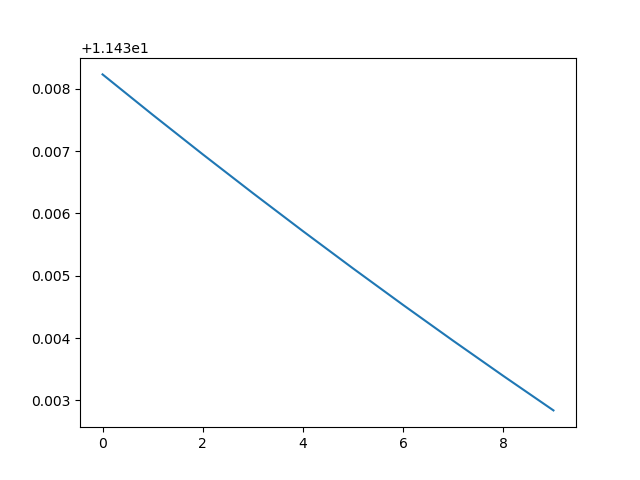

In [32]:
# let's look at the loss history!
print(loss_history)
plt.plot(loss_history)

In [72]:
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=300, learning_rate=1e-1, batch_size=300, reg=1e-1)

[[1.12961879e-05 1.10836133e-05 1.12129798e-05 ... 1.10036920e-05 [8 9 5 ... 2 9 9]
  1.12686908e-05 1.09134054e-05]                                                   
 [1.11655850e-05 1.11185976e-05 1.12016087e-05 ... 1.10159565e-05                  
  1.11744179e-05 1.11428707e-05]                                                   
 [1.11314281e-05 1.10873136e-05 1.12929469e-05 ... 1.10494744e-05                  
  1.11980497e-05 1.11260559e-05]                                                   
 ...                                                                               
 [1.12956527e-05 1.10531817e-05 1.10973684e-05 ... 1.09589177e-05                  
  1.11114147e-05 1.10693195e-05]                                                   
 [1.10830557e-05 1.11214133e-05 1.12813685e-05 ... 1.09535730e-05                  
  1.12147412e-05 1.12017369e-05]                                                   
 [1.12179406e-05 1.11395946e-05 1.13608702e-05 ... 1.08220957e-05           

[[1.03026858e-05 1.28382413e-05 1.11300530e-05 ... 1.08537232e-05 [2 6 2 ... 5 3 7]
  1.03517130e-05 1.04865067e-05]                                                   
 [1.12088270e-05 1.25383661e-05 1.15120936e-05 ... 1.02727747e-05                  
  1.13277764e-05 1.09876745e-05]                                                   
 [1.09643089e-05 1.11624256e-05 1.22398786e-05 ... 1.10751245e-05                  
  1.07460170e-05 1.07245194e-05]                                                   
 ...                                                                               
 [1.07700451e-05 1.16691841e-05 1.13235470e-05 ... 1.13513923e-05                  
  1.10034766e-05 1.07323116e-05]                                                   
 [1.05060615e-05 1.22220618e-05 1.09122795e-05 ... 1.11376389e-05                  
  1.04567236e-05 1.04373707e-05]                                                   
 [1.08571935e-05 1.11570693e-05 1.20832220e-05 ... 1.17186456e-05           

[[1.01654959e-05 1.18843062e-05 1.15393321e-05 ... 1.17387721e-05 [9 1 1 ... 8 0 3]
  1.07691762e-05 1.07098111e-05]                                                   
 [9.80485881e-06 1.16343950e-05 1.15822256e-05 ... 1.17838162e-05                  
  1.03088731e-05 1.04982249e-05]                                                   
 [1.04590495e-05 1.41892459e-05 1.20995901e-05 ... 1.02392428e-05                  
  1.05594812e-05 1.07630695e-05]                                                   
 ...                                                                               
 [9.98128321e-06 1.10555102e-05 1.16056702e-05 ... 1.00980427e-05                  
  1.22706098e-05 1.12076142e-05]                                                   
 [1.27887577e-05 1.41951999e-05 1.11446399e-05 ... 1.12896803e-05                  
  9.93675517e-06 1.04545508e-05]                                                   
 [1.07918298e-05 1.14203120e-05 1.20789861e-05 ... 1.07976231e-05           

[[9.39473306e-06 1.26138382e-05 1.19705861e-05 ... 1.19697006e-05 [3 2 3 ... 2 7 1]
  9.52116234e-06 1.02433373e-05]                                                   
 [1.10030622e-05 1.29498816e-05 1.24989651e-05 ... 1.00042669e-05                  
  1.09113447e-05 1.00426298e-05]                                                   
 [1.01459790e-05 1.42491794e-05 1.15698210e-05 ... 1.20549264e-05                  
  9.24086500e-06 1.02459239e-05]                                                   
 ...                                                                               
 [1.03654476e-05 1.31726716e-05 1.18160452e-05 ... 1.09321290e-05                  
  1.00994445e-05 1.03396215e-05]                                                   
 [1.08787018e-05 1.46680498e-05 1.15219696e-05 ... 1.02435308e-05                  
  1.02862865e-05 1.00432911e-05]                                                   
 [1.08529627e-05 1.31649105e-05 1.22284061e-05 ... 1.04118449e-05           

Epoch 33, loss: 11.347585
== W == -0.1326994028766661
[[9.86957884e-06 1.62808851e-05 1.23766878e-05 ... 1.08440655e-05 [4 5 7 ... 4 8 1]
  9.59673662e-06 9.00963589e-06]                                                   
 [1.04985455e-05 1.24015043e-05 1.09737456e-05 ... 1.12956815e-05                  
  1.04758006e-05 9.80066955e-06]                                                   
 [8.46950661e-06 1.89884629e-05 6.70492067e-06 ... 1.12882996e-05                  
  1.05833458e-05 9.24044807e-06]                                                   
 ...                                                                               
 [1.07457535e-05 1.52455942e-05 1.08060784e-05 ... 1.34947262e-05                  
  9.41827472e-06 9.72126210e-06]                                                   
 [1.01305772e-05 1.48646882e-05 1.25507666e-05 ... 8.84138139e-06                  
  1.15913860e-05 1.01175938e-05]                                                   
 [9.33313318e-06 1.526

[[9.19112487e-06 1.38318881e-05 1.24791676e-05 ... 1.12054309e-05 [8 7 8 ... 4 8 5]
  1.01712678e-05 1.02217358e-05]                                                   
 [1.18613745e-05 1.69908320e-05 1.32459499e-05 ... 9.83142383e-06                  
  9.04311094e-06 1.05788439e-05]                                                   
 [1.04989811e-05 1.27537185e-05 1.34794381e-05 ... 9.77553727e-06                  
  1.02912456e-05 1.00603686e-05]                                                   
 ...                                                                               
 [9.96737526e-06 1.69152594e-05 1.15132452e-05 ... 1.13797208e-05                  
  9.83208978e-06 9.19838513e-06]                                                   
 [1.11082860e-05 1.83841810e-05 1.14745619e-05 ... 1.01936437e-05                  
  9.05010375e-06 9.49018428e-06]                                                   
 [9.89104225e-06 1.31834585e-05 1.24581266e-05 ... 9.16204349e-06           

[[1.07431130e-05 1.31681433e-05 1.06671341e-05 ... 9.20893262e-06 [6 2 3 ... 1 1 4]
  1.19654741e-05 1.04103323e-05]                                                   
 [1.02045018e-05 1.33960842e-05 1.80497358e-05 ... 9.31204485e-06                  
  9.90327011e-06 9.40808534e-06]                                                   
 [1.10862291e-05 1.88271869e-05 1.19948123e-05 ... 9.71491405e-06                  
  9.80320487e-06 1.00918439e-05]                                                   
 ...                                                                               
 [1.02257541e-05 1.40219001e-05 1.35147414e-05 ... 9.72136756e-06                  
  1.10057238e-05 9.81831936e-06]                                                   
 [8.61946046e-06 1.26637184e-05 1.20544026e-05 ... 1.22217305e-05                  
  9.57279569e-06 9.84704640e-06]                                                   
 [1.08525447e-05 1.76845677e-05 1.17756708e-05 ... 1.01881215e-05           

[[1.04311947e-05 1.41752771e-05 1.27104336e-05 ... 1.17362686e-05 [0 2 1 ... 4 7 3]
  8.83876759e-06 9.55937020e-06]                                                   
 [9.32479672e-06 1.62138221e-05 1.42226774e-05 ... 1.02609830e-05                  
  9.79489986e-06 1.04348756e-05]                                                   
 [9.04117802e-06 1.40165193e-05 1.46015023e-05 ... 9.59665877e-06                  
  1.10483933e-05 1.05794372e-05]                                                   
 ...                                                                               
 [1.07535053e-05 1.82035181e-05 1.00033220e-05 ... 8.60328486e-06                  
  9.86504311e-06 1.10123254e-05]                                                   
 [8.62161534e-06 1.29994897e-05 1.81664829e-05 ... 1.12389130e-05                  
  1.06130751e-05 1.06373122e-05]                                                   
 [1.06435211e-05 1.15621654e-05 1.35218284e-05 ... 1.30125199e-05           

[[8.72139884e-06 1.41790067e-05 1.28063495e-05 ... 1.09154071e-05 [1 0 5 ... 9 4 9]
  1.17056796e-05 9.25302043e-06]                                                   
 [1.03319778e-05 1.84339325e-05 1.21047793e-05 ... 1.23916339e-05                  
  9.45405211e-06 9.12505260e-06]                                                   
 [8.84263450e-06 1.37009782e-05 1.36389065e-05 ... 1.00931735e-05                  
  1.04779671e-05 9.49786827e-06]                                                   
 ...                                                                               
 [9.33543489e-06 1.39769723e-05 1.40451415e-05 ... 8.95080732e-06                  
  1.11423530e-05 1.08883461e-05]                                                   
 [9.52549379e-06 1.47674596e-05 1.42047452e-05 ... 9.26166555e-06                  
  9.77463947e-06 8.71498671e-06]                                                   
 [9.81857122e-06 1.20821189e-05 1.43027564e-05 ... 1.02835688e-05           

[[1.06155064e-05 1.93168437e-05 1.38080182e-05 ... 9.15491616e-06 [1 6 2 ... 4 3 6]
  9.81447644e-06 8.94649916e-06]                                                   
 [1.01888911e-05 1.64450702e-05 1.20610337e-05 ... 9.01756342e-06                  
  1.14024222e-05 8.77190679e-06]                                                   
 [7.56657564e-06 2.96043932e-05 9.00626467e-06 ... 1.01723759e-05                  
  7.45421030e-06 9.65359719e-06]                                                   
 ...                                                                               
 [8.86873739e-06 1.58027827e-05 1.41120293e-05 ... 1.04391667e-05                  
  9.31626637e-06 9.41369781e-06]                                                   
 [9.68925135e-06 1.72570190e-05 1.30141573e-05 ... 1.05583559e-05                  
  9.64108821e-06 9.04187039e-06]                                                   
 [9.44100406e-06 1.39852785e-05 1.18300703e-05 ... 1.26858318e-05           

[[9.59460185e-06 1.92021793e-05 1.22527157e-05 ... 8.75390558e-06 [1 2 2 ... 6 5 3]
  8.20997355e-06 9.21729888e-06]                                                   
 [9.30119957e-06 1.73097704e-05 1.35727582e-05 ... 9.50340760e-06                  
  9.34334736e-06 9.26934689e-06]                                                   
 [9.39314180e-06 1.40081457e-05 1.33095241e-05 ... 1.05980043e-05                  
  1.02263295e-05 8.69158338e-06]                                                   
 ...                                                                               
 [8.69572238e-06 1.55210672e-05 1.44127677e-05 ... 1.05306221e-05                  
  9.58643132e-06 8.13392607e-06]                                                   
 [1.16090881e-05 1.48810237e-05 1.12732365e-05 ... 8.67559428e-06                  
  1.02768806e-05 9.15693065e-06]                                                   
 [7.60987539e-06 1.71258043e-05 1.51794206e-05 ... 9.84327369e-06           

[[9.71066229e-06 1.94945195e-05 1.29662167e-05 ... 8.48632716e-06 [1 0 7 ... 9 3 9]
  9.89076421e-06 8.65206895e-06]                                                   
 [1.00163935e-05 1.80950805e-05 1.33212060e-05 ... 8.97301909e-06                  
  8.60769976e-06 9.73430660e-06]                                                   
 [7.68975701e-06 2.66375955e-05 5.12572296e-06 ... 1.38877615e-05                  
  8.59365341e-06 7.60086152e-06]                                                   
 ...                                                                               
 [9.53900045e-06 1.57602871e-05 1.26320803e-05 ... 1.03423159e-05                  
  9.56223988e-06 9.78756004e-06]                                                   
 [9.17691591e-06 1.38491250e-05 1.27612512e-05 ... 9.92788373e-06                  
  1.04350562e-05 8.57813517e-06]                                                   
 [9.73564943e-06 1.52243026e-05 1.33077791e-05 ... 8.38577598e-06           

[[9.93299311e-06 1.92313121e-05 1.48972866e-05 ... 7.70372072e-06 [9 3 2 ... 5 6 1]
  8.49741841e-06 9.21718845e-06]                                                   
 [7.21682098e-06 1.56293110e-05 1.18835585e-05 ... 1.13515526e-05                  
  9.25012260e-06 8.57136865e-06]                                                   
 [8.52720910e-06 1.82284785e-05 1.20751835e-05 ... 1.15763866e-05                  
  8.54591305e-06 9.60638793e-06]                                                   
 ...                                                                               
 [9.45304878e-06 1.64760471e-05 1.31954863e-05 ... 9.60417138e-06                  
  8.80354831e-06 1.00188262e-05]                                                   
 [8.62384799e-06 1.51484123e-05 1.18255548e-05 ... 9.72632190e-06                  
  1.04489302e-05 9.51961156e-06]                                                   
 [9.99678743e-06 1.68275578e-05 1.42402783e-05 ... 9.05408623e-06           

[[9.48269393e-06 1.45613870e-05 1.24517100e-05 ... 1.04669151e-05 [5 9 4 ... 0 6 1]
  9.15647536e-06 8.90421540e-06]                                                   
 [1.17529147e-05 1.65885912e-05 1.47502907e-05 ... 6.70040577e-06                  
  9.65405322e-06 9.48657110e-06]                                                   
 [9.83008366e-06 1.34935710e-05 1.39022577e-05 ... 1.00114872e-05                  
  9.85998197e-06 9.54869397e-06]                                                   
 ...                                                                               
 [9.74872913e-06 1.61955273e-05 1.33614585e-05 ... 8.83311085e-06                  
  9.32897719e-06 8.44614723e-06]                                                   
 [9.24083059e-06 1.50537416e-05 1.22410750e-05 ... 9.08936738e-06                  
  1.06217593e-05 9.06857702e-06]                                                   
 [8.37575026e-06 1.24667022e-05 1.23721906e-05 ... 1.34014778e-05           

[[7.97916709e-06 1.57273152e-05 1.43283570e-05 ... 1.09880957e-05 [1 1 8 ... 1 1 9]
  9.48134897e-06 8.89490202e-06]                                                   
 [9.05367761e-06 1.67292783e-05 1.40638734e-05 ... 1.01249422e-05                  
  8.91761893e-06 9.00586132e-06]                                                   
 [8.29016148e-06 1.20443154e-05 1.34763196e-05 ... 1.02069134e-05                  
  1.15276163e-05 9.44286962e-06]                                                   
 ...                                                                               
 [9.69532876e-06 1.91638210e-05 1.31573003e-05 ... 8.94068925e-06                  
  9.10691808e-06 9.77831058e-06]                                                   
 [8.97241825e-06 1.42350467e-05 9.65153208e-06 ... 1.18328233e-05                  
  8.70320593e-06 9.42842165e-06]                                                   
 [8.89321314e-06 1.54499360e-05 1.28560372e-05 ... 1.02550710e-05           

[[1.09007480e-05 1.42368395e-05 1.38428545e-05 ... 9.03903263e-06 [8 2 1 ... 8 1 8]
  9.47018160e-06 9.06556388e-06]                                                   
 [9.33356111e-06 1.93381156e-05 1.03302025e-05 ... 1.08166345e-05                  
  9.17761707e-06 9.25909177e-06]                                                   
 [7.12524317e-06 2.14789467e-05 1.44792105e-05 ... 1.06171456e-05                  
  8.23699398e-06 8.89822392e-06]                                                   
 ...                                                                               
 [8.63747730e-06 1.61759576e-05 1.63738569e-05 ... 1.05120761e-05                  
  8.25699977e-06 9.10777045e-06]                                                   
 [1.07124220e-05 2.99125686e-05 1.11185430e-05 ... 9.77089940e-06                  
  7.84110603e-06 7.85906916e-06]                                                   
 [9.78102881e-06 1.47790936e-05 1.13895654e-05 ... 1.00541714e-05           

[[7.95686548e-06 1.86065105e-05 1.22150857e-05 ... 9.87557658e-06 [3 6 5 ... 2 6 3]
  9.33978341e-06 8.85209493e-06]                                                   
 [9.03793120e-06 1.59157537e-05 1.26803524e-05 ... 1.07823286e-05                  
  8.19696171e-06 9.39621917e-06]                                                   
 [9.06945046e-06 1.72844826e-05 1.29571715e-05 ... 1.05854150e-05                  
  9.58508586e-06 9.26521508e-06]                                                   
 ...                                                                               
 [8.27048859e-06 1.75763436e-05 1.49467009e-05 ... 1.29016269e-05                  
  7.58292243e-06 8.86684227e-06]                                                   
 [8.56404002e-06 1.37734661e-05 1.56743480e-05 ... 9.35567898e-06                  
  9.40276823e-06 8.70406442e-06]                                                   
 [1.31482757e-05 1.92319955e-05 1.49737512e-05 ... 7.81747628e-06           

[[9.95766867e-06 1.48847028e-05 1.53430690e-05 ... 9.41116444e-06 [6 5 4 ... 9 8 1]
  8.66680345e-06 9.86116348e-06]                                                   
 [8.30864753e-06 1.49820791e-05 1.15286282e-05 ... 9.92185366e-06                  
  9.10998396e-06 9.40791927e-06]                                                   
 [8.68866746e-06 1.85015421e-05 1.24053214e-05 ... 8.47825719e-06                  
  9.20209581e-06 7.79644665e-06]                                                   
 ...                                                                               
 [8.27178910e-06 1.32862859e-05 1.56355902e-05 ... 1.14176714e-05                  
  1.07302608e-05 1.00419780e-05]                                                   
 [8.49044709e-06 1.33512540e-05 1.48649877e-05 ... 9.51202595e-06                  
  1.02323043e-05 9.31093855e-06]                                                   
 [9.59600013e-06 1.39154002e-05 1.42235462e-05 ... 1.09794484e-05           

[[9.95129964e-06 1.49121586e-05 1.53636227e-05 ... 9.40296663e-06 [6 0 2 ... 1 8 6]
  8.65052283e-06 9.84877898e-06]                                                   
 [1.19435845e-05 1.27872852e-05 1.31183089e-05 ... 9.24486549e-06                  
  9.14995584e-06 9.74199972e-06]                                                   
 [8.88674750e-06 2.10494773e-05 1.17284136e-05 ... 1.21040498e-05                  
  7.13256049e-06 8.47053990e-06]                                                   
 ...                                                                               
 [8.80358455e-06 2.01528808e-05 1.38793488e-05 ... 9.00785859e-06                  
  9.04489522e-06 8.35839267e-06]                                                   
 [9.17516142e-06 1.60543762e-05 1.26315601e-05 ... 9.77220061e-06                  
  9.38267250e-06 1.04149142e-05]                                                   
 [9.53156744e-06 1.85180322e-05 1.39038893e-05 ... 1.01869615e-05           

[[1.27187002e-05 1.72074872e-05 1.47655600e-05 ... 7.19685102e-06 [4 4 8 ... 2 1 1]
  9.12448354e-06 8.09218367e-06]                                                   
 [8.65805927e-06 1.55521669e-05 1.32320427e-05 ... 9.63044084e-06                  
  8.75316101e-06 9.97873180e-06]                                                   
 [7.48640947e-06 1.26130761e-05 1.12971732e-05 ... 6.99942709e-06                  
  1.47593044e-05 9.32304588e-06]                                                   
 ...                                                                               
 [8.97858167e-06 1.67386928e-05 1.59678775e-05 ... 8.06692233e-06                  
  9.73106103e-06 8.54820434e-06]                                                   
 [9.46814683e-06 1.65446145e-05 1.29278758e-05 ... 1.01858376e-05                  
  8.20585359e-06 8.39694509e-06]                                                   
 [9.60745809e-06 1.88493600e-05 1.30769398e-05 ... 8.91043095e-06           

[[1.01210252e-05 1.39320253e-05 9.66160813e-06 ... 1.14637364e-05 [3 4 5 ... 5 7 9]
  9.14623414e-06 1.03262396e-05]                                                   
 [9.07545360e-06 1.92802422e-05 1.22295318e-05 ... 1.07082720e-05                  
  7.58105300e-06 1.02949431e-05]                                                   
 [1.02349476e-05 1.87556117e-05 1.43756833e-05 ... 1.18489508e-05                  
  8.37287430e-06 9.35307854e-06]                                                   
 ...                                                                               
 [8.73887678e-06 1.64680101e-05 1.26470525e-05 ... 1.02243961e-05                  
  9.86934955e-06 8.59590437e-06]                                                   
 [1.04729270e-05 1.81493562e-05 1.28552413e-05 ... 8.04688442e-06                  
  9.27658582e-06 8.23524659e-06]                                                   
 [1.05800634e-05 1.61009613e-05 1.42794151e-05 ... 1.00693428e-05           

[[9.93698702e-06 1.10047135e-05 1.26663584e-05 ... 9.32261541e-06 [6 1 4 ... 3 5 8]
  1.09472062e-05 8.00978189e-06]                                                   
 [8.87216509e-06 1.83375677e-05 1.11578852e-05 ... 9.67082659e-06                  
  8.71874108e-06 1.03541634e-05]                                                   
 [1.06435693e-05 1.47544161e-05 1.29564365e-05 ... 9.82815607e-06                  
  8.78481551e-06 9.25353322e-06]                                                   
 ...                                                                               
 [7.98417175e-06 1.67422739e-05 1.36926929e-05 ... 9.41583908e-06                  
  9.10069177e-06 9.24998344e-06]                                                   
 [1.05612434e-05 1.61690985e-05 1.39379939e-05 ... 9.44216219e-06                  
  9.71053063e-06 8.57367985e-06]                                                   
 [1.11972032e-05 1.25040291e-05 1.16976330e-05 ... 9.92415665e-06           

[[9.55335661e-06 1.92706309e-05 1.75921323e-05 ... 6.78949820e-06 [2 5 8 ... 0 5 6]
  9.04850059e-06 8.33190476e-06]                                                   
 [1.03152120e-05 1.62612702e-05 1.82907763e-05 ... 1.01651982e-05                  
  7.81997229e-06 9.53049028e-06]                                                   
 [1.04498208e-05 1.49618576e-05 1.38848168e-05 ... 8.26339641e-06                  
  9.57959932e-06 1.05044560e-05]                                                   
 ...                                                                               
 [8.67729505e-06 1.61643781e-05 1.24234818e-05 ... 8.44789603e-06                  
  1.20711039e-05 9.50707638e-06]                                                   
 [8.63457142e-06 1.39689252e-05 1.47009097e-05 ... 1.01796894e-05                  
  1.15523685e-05 8.89545822e-06]                                                   
 [1.02580700e-05 1.88008663e-05 1.32544937e-05 ... 9.24610402e-06           

[[8.55720552e-06 2.20906763e-05 1.07158746e-05 ... 1.07579482e-05 [1 6 9 ... 5 1 1]
  8.35385736e-06 8.78172599e-06]                                                   
 [8.35419264e-06 1.60338730e-05 1.34674010e-05 ... 1.03241045e-05                  
  9.61225568e-06 8.92736050e-06]                                                   
 [8.61269197e-06 1.32780676e-05 1.48887992e-05 ... 1.06243816e-05                  
  9.23662579e-06 8.52887426e-06]                                                   
 ...                                                                               
 [8.64010752e-06 1.35298101e-05 1.18731815e-05 ... 9.65994119e-06                  
  1.21887988e-05 8.78089456e-06]                                                   
 [9.75940778e-06 1.64300525e-05 1.28859563e-05 ... 9.86503711e-06                  
  8.72811837e-06 8.25705469e-06]                                                   
 [8.02680548e-06 2.56007147e-05 1.59072806e-05 ... 6.81161822e-06           

[[9.11985221e-06 2.00609671e-05 1.64340689e-05 ... 8.92602087e-06 [1 4 1 ... 0 1 5]
  7.91158064e-06 7.88115785e-06]                                                   
 [7.40090036e-06 1.64036844e-05 1.28912524e-05 ... 1.17542124e-05                  
  8.56923075e-06 9.86900689e-06]                                                   
 [8.77930449e-06 1.78610255e-05 1.37735353e-05 ... 1.06300494e-05                  
  8.90319786e-06 9.02011268e-06]                                                   
 ...                                                                               
 [1.05081737e-05 1.17575249e-05 1.77523453e-05 ... 7.69260939e-06                  
  1.04753046e-05 1.07040715e-05]                                                   
 [8.90494857e-06 1.73838881e-05 1.37787981e-05 ... 9.65035603e-06                  
  9.89733211e-06 8.58673391e-06]                                                   
 [8.35298158e-06 2.16433674e-05 1.04653981e-05 ... 8.63901554e-06           

[[8.96443395e-06 1.49138764e-05 1.28016410e-05 ... 1.21269827e-05 [6 1 5 ... 1 3 3]
  9.30142174e-06 9.64075194e-06]                                                   
 [9.22504473e-06 1.73997558e-05 1.58754664e-05 ... 8.52610320e-06                  
  9.18221569e-06 9.15316408e-06]                                                   
 [9.08557023e-06 1.90171443e-05 1.64253853e-05 ... 9.31193743e-06                  
  6.90016487e-06 1.00870147e-05]                                                   
 ...                                                                               
 [9.19036905e-06 3.39307493e-05 1.07165511e-05 ... 8.56775218e-06                  
  7.09419780e-06 7.65483803e-06]                                                   
 [6.80498166e-06 1.52264102e-05 1.24675935e-05 ... 9.61747335e-06                  
  9.80307887e-06 9.64764444e-06]                                                   
 [9.01445150e-06 1.77980186e-05 1.47283851e-05 ... 9.38445047e-06           

[[1.02357334e-05 1.52829026e-05 1.33999979e-05 ... 7.16769158e-06 [8 5 2 ... 0 3 2]
  1.05819582e-05 1.11647649e-05]                                                   
 [8.28436607e-06 1.64008220e-05 1.35866057e-05 ... 9.74119116e-06                  
  9.06103494e-06 8.59503845e-06]                                                   
 [8.92956056e-06 1.50344251e-05 1.60274247e-05 ... 7.72181258e-06                  
  7.73543928e-06 9.98563591e-06]                                                   
 ...                                                                               
 [9.16121212e-06 1.81603466e-05 1.37080766e-05 ... 9.78302729e-06                  
  8.92840902e-06 8.31975353e-06]                                                   
 [7.72618045e-06 1.64260642e-05 1.20475344e-05 ... 9.50702164e-06                  
  8.84625035e-06 9.55651100e-06]                                                   
 [8.94236528e-06 1.86716217e-05 1.36927919e-05 ... 9.66852642e-06           

[[8.85091303e-06 1.52763514e-05 1.27017830e-05 ... 9.07751216e-06 [3 2 3 ... 0 2 1]
  9.49800415e-06 8.98693593e-06]                                                   
 [8.80495879e-06 1.83017764e-05 1.61038028e-05 ... 9.43003383e-06                  
  7.19399806e-06 9.92127079e-06]                                                   
 [1.01587979e-05 1.34379784e-05 1.44401450e-05 ... 9.68185729e-06                  
  1.03964589e-05 9.05074186e-06]                                                   
 ...                                                                               
 [1.18505869e-05 1.18572332e-05 1.30898774e-05 ... 8.65744796e-06                  
  1.01653464e-05 9.23487893e-06]                                                   
 [9.48778653e-06 1.31245765e-05 1.65590932e-05 ... 1.01615985e-05                  
  9.23069937e-06 9.07925881e-06]                                                   
 [9.56051074e-06 1.50079995e-05 1.21700932e-05 ... 1.02789858e-05           

[[9.55748984e-06 1.54353010e-05 1.32749803e-05 ... 8.75938753e-06 [4 7 1 ... 1 7 2]
  9.48421405e-06 9.41521831e-06]                                                   
 [8.42565331e-06 1.86449494e-05 1.17101814e-05 ... 9.43716642e-06                  
  9.19784162e-06 7.50856086e-06]                                                   
 [1.11157409e-05 1.41390638e-05 1.42067965e-05 ... 8.99461820e-06                  
  8.72445948e-06 9.23046580e-06]                                                   
 ...                                                                               
 [8.32974688e-06 1.92960302e-05 1.38014267e-05 ... 9.42724367e-06                  
  9.76824314e-06 8.55465294e-06]                                                   
 [8.38091751e-06 1.72735911e-05 1.55836665e-05 ... 1.11247872e-05                  
  8.51209180e-06 8.24160369e-06]                                                   
 [8.44897977e-06 1.43088315e-05 2.02516571e-05 ... 1.02610505e-05           

[[9.16164719e-06 1.54338095e-05 1.34057235e-05 ... 1.07361606e-05 [1 3 1 ... 1 2 6]
  9.57364817e-06 8.65224639e-06]                                                   
 [1.02201733e-05 1.56949481e-05 1.81623716e-05 ... 7.07544139e-06                  
  1.13419985e-05 9.91268058e-06]                                                   
 [9.46763594e-06 1.84983724e-05 1.39526024e-05 ... 9.74825750e-06                  
  9.29645695e-06 8.42841761e-06]                                                   
 ...                                                                               
 [9.45509582e-06 2.15233032e-05 1.14933753e-05 ... 1.07008158e-05                  
  7.27113620e-06 8.52129900e-06]                                                   
 [9.61406722e-06 2.26950156e-05 1.38954318e-05 ... 8.56536604e-06                  
  7.74300691e-06 9.27440395e-06]                                                   
 [8.57748582e-06 2.01846358e-05 8.63808758e-06 ... 1.06711926e-05           

[[9.57483744e-06 2.15995148e-05 1.04088580e-05 ... 8.30072999e-06 [1 8 1 ... 1 9 5]
  1.11974540e-05 9.14082973e-06]                                                   
 [9.41799922e-06 1.66417550e-05 1.45118234e-05 ... 1.00747393e-05                  
  8.41400426e-06 8.70718190e-06]                                                   
 [8.31791249e-06 1.93152799e-05 1.38003443e-05 ... 9.42614910e-06                  
  9.76007186e-06 8.54483872e-06]                                                   
 ...                                                                               
 [9.47029263e-06 1.79638114e-05 1.55450252e-05 ... 9.99376203e-06                  
  9.56438557e-06 1.06941456e-05]                                                   
 [1.01647062e-05 1.42202553e-05 1.62280347e-05 ... 1.05315170e-05                  
  8.65211533e-06 9.76420178e-06]                                                   
 [8.76096782e-06 1.58287049e-05 9.91208600e-06 ... 1.04630977e-05           

[[9.35131816e-06 1.69287161e-05 1.25883632e-05 ... 1.22685369e-05 [2 3 8 ... 7 2 7]
  8.44058053e-06 8.87721078e-06]                                                   
 [6.81945833e-06 2.33804105e-05 1.38295217e-05 ... 8.35876360e-06                  
  8.64758915e-06 8.25749098e-06]                                                   
 [9.35034854e-06 2.12184060e-05 1.32855653e-05 ... 7.48662271e-06                  
  1.01681445e-05 8.56253047e-06]                                                   
 ...                                                                               
 [8.95122510e-06 1.31070146e-05 1.84473100e-05 ... 1.10622269e-05                  
  9.00875421e-06 9.22475586e-06]                                                   
 [9.39703353e-06 1.51684344e-05 1.22743419e-05 ... 8.55440702e-06                  
  9.26815581e-06 1.01045901e-05]                                                   
 [9.85882094e-06 1.61068799e-05 1.37337339e-05 ... 1.17941956e-05           

[[8.77180131e-06 1.59605091e-05 1.29953134e-05 ... 8.67581463e-06 [6 1 1 ... 2 6 3]
  1.02151678e-05 9.41451275e-06]                                                   
 [9.79146023e-06 1.52833681e-05 1.51084360e-05 ... 9.06380148e-06                  
  1.12308073e-05 8.91988252e-06]                                                   
 [7.31884914e-06 1.88620246e-05 1.44112483e-05 ... 9.54991784e-06                  
  8.66599603e-06 9.43276482e-06]                                                   
 ...                                                                               
 [8.73465245e-06 1.49581604e-05 1.53571323e-05 ... 1.08651177e-05                  
  9.24598753e-06 9.66291763e-06]                                                   
 [8.80900024e-06 1.65553027e-05 1.61453768e-05 ... 8.92414509e-06                  
  9.48800989e-06 9.47826058e-06]                                                   
 [1.30893095e-05 1.88265303e-05 1.08619423e-05 ... 1.06237277e-05           

[[1.14743874e-05 1.82990927e-05 1.63402270e-05 ... 7.46015671e-06 [3 2 8 ... 1 2 2]
  8.24412361e-06 9.26109954e-06]                                                   
 [9.17918012e-06 1.47662398e-05 2.14082841e-05 ... 8.52479578e-06                  
  9.40684266e-06 8.94133261e-06]                                                   
 [8.38941675e-06 8.47218820e-06 1.54531961e-05 ... 8.94718151e-06                  
  1.14845846e-05 1.02338760e-05]                                                   
 ...                                                                               
 [4.90116463e-06 4.75320513e-05 1.61636323e-05 ... 6.37816250e-06                  
  6.21976712e-06 8.68497101e-06]                                                   
 [9.83129296e-06 1.40390240e-05 3.36861493e-05 ... 7.15869095e-06                  
  9.28652027e-06 9.01873306e-06]                                                   
 [9.33290835e-06 1.34731703e-05 1.27039036e-05 ... 1.05392578e-05           

[11.408333822818985, 11.404557163342373, 11.401571305725955, 11.398760718281874, 11.39606730384471, 11.393479541658378, 11.39099053845141, 11.388594382631089, 11.38628573954004, 11.384059751897627, 11.38191198074332, 11.379838357920555, 11.37783514523431, 11.375898898755278, 11.374026437455994, 11.372214815596399, 11.370461298386184, 11.368763340521593, 11.367118567247376, 11.365524757638688, 11.363979829835007, 11.362481827990466, 11.361028910733415, 11.359619340952447, 11.358251476748146, 11.35692376340877, 11.355634726285134, 11.35438296445483, 11.35316714507915, 11.351985998367867, 11.35083831307723, 11.349722932475819, 11.348638750720912, 11.347584709595171, 11.346559795559722, 11.345563037085283, 11.344593502227806, 11.343650296419447, 11.342732560449303, 11.341839468611786, 11.340970227003249, 11.340124071950047, 11.339300268553357, 11.338498109338017, 11.337716912994289, 11.336956023202815, 11.336214807534434, 11.335492656417415, 11.33478898216572, 11.334103218062735, 11.333434

<IPython.core.display.Javascript object>


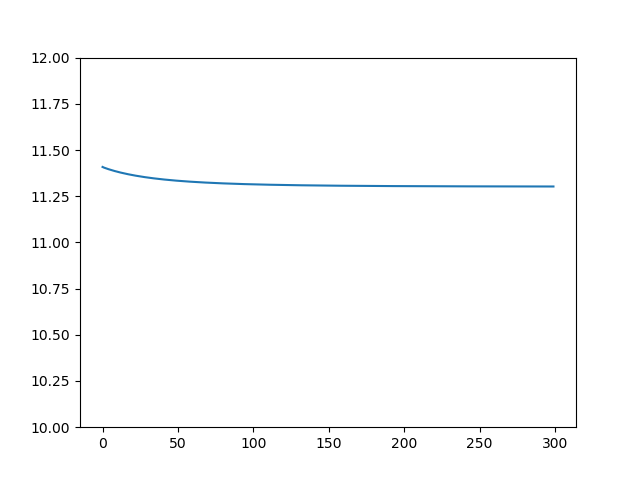

(10, 12)

In [73]:
print(loss_history)
plt.plot(loss_history)
plt.gca().set_ylim(10,12)

log loss =  102664.42468084252
Epoch 0, loss: 11.438023
== W == -6.036378324860552
log loss =  136800.60254381853
Epoch 1, loss: 320.642178
== W == 1415.6879791892497


D:\Python\layman-s-Deep-Learning-\assignments\assignment1\linear_classifer.py:38: RuntimeWarning: divide by zero encountered in log
  log =   np.sum(- np.log(probs[np.arange(probs.shape[0]),target_index.flatten()]))


log loss =  inf
Epoch 2, loss: inf
== W == -155492.7233192813
log loss =  inf
Epoch 3, loss: inf
== W == 15404846.74032562
log loss =  inf
Epoch 4, loss: inf
== W == -1525095166.9056184
log loss =  inf
Epoch 5, loss: inf
== W == 150984432590.78793
log loss =  inf
Epoch 6, loss: inf
== W == -14947458841827.623
log loss =  inf
Epoch 7, loss: inf
== W == 1479798425352002.0
log loss =  inf
Epoch 8, loss: inf
== W == -1.4650004410986355e+17
log loss =  inf
Epoch 9, loss: inf
== W == 1.450350436687649e+19
log loss =  inf
Epoch 0, loss: inf
== W == -1.4358469323207722e+21
log loss =  inf
Epoch 1, loss: inf
== W == 1.421488462997565e+23
log loss =  inf
Epoch 2, loss: inf
== W == -1.407273578367589e+25
log loss =  inf
Epoch 3, loss: inf
== W == 1.3932008425839132e+27
log loss =  inf
Epoch 4, loss: inf
== W == -1.3792688341580739e+29
log loss =  inf
Epoch 5, loss: inf
== W == 1.3654761458164933e+31
log loss =  inf
Epoch 6, loss: inf
== W == -1.3518213843583285e+33
log loss =  inf
Epoch 7, loss: 

c:\users\сергей\.virtualenvs\layman-s-deep-learning--lrbitjvr\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Python\layman-s-Deep-Learning-\assignments\assignment1\linear_classifer.py:98: RuntimeWarning: overflow encountered in square
  loss = reg_strength * np.sum(W**2)


Epoch 8, loss: inf
== W == -7.249388545869601e+156
log loss =  inf
Epoch 9, loss: inf
== W == 7.176894660410911e+158
log loss =  inf
Epoch 0, loss: inf
== W == -7.1051257138068e+160
log loss =  inf
Epoch 1, loss: inf
== W == 7.034074456668732e+162
log loss =  inf
Epoch 2, loss: inf
== W == -6.963733712102046e+164
log loss =  inf
Epoch 3, loss: inf
== W == 6.894096374981025e+166
log loss =  inf
Epoch 4, loss: inf
== W == -6.825155411231221e+168
log loss =  inf
Epoch 5, loss: inf
== W == 6.756903857118903e+170
log loss =  inf
Epoch 6, loss: inf
== W == -6.689334818547713e+172
log loss =  inf
Epoch 7, loss: inf
== W == 6.622441470362236e+174
log loss =  inf
Epoch 8, loss: inf
== W == -6.556217055658617e+176
log loss =  inf
Epoch 9, loss: inf
== W == 6.490654885102029e+178
log loss =  inf
Epoch 0, loss: inf
== W == -6.4257483362510075e+180
log loss =  inf
Epoch 1, loss: inf
== W == 6.361490852888499e+182
log loss =  inf
Epoch 2, loss: inf
== W == -6.297875944359614e+184
log loss =  inf
Epo

c:\users\сергей\.virtualenvs\layman-s-deep-learning--lrbitjvr\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Python\layman-s-Deep-Learning-\assignments\assignment1\linear_classifer.py:15: RuntimeWarning: invalid value encountered in subtract
  s_pred =predictions-np.max(predictions)



== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan


log loss =  inf
Epoch 2, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 3, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 4, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 5, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 6, loss: inf
== W == 11067.131716775599
log loss =  inf
Epoch 7, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 8, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 9, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 0, loss: inf
== W == 11067.131716775599
log loss =  inf
Epoch 1, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 2, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 3, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 4, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 5, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 6, loss: inf
== W == 11067.131716775599
log loss =  inf
Epoch 7, loss: inf
== W == -15348.907498910678


log loss =  inf
Epoch 5, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 6, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 7, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 8, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 9, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 0, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 1, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 2, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 3, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 4, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 5, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 6, loss: inf
== W == 11067.131716775599
log loss =  inf
Epoch 7, loss: inf
== W == -15348.907498910678
log loss =  inf
Epoch 8, loss: inf
== W == 11067.131716775602
log loss =  inf
Epoch 9, loss: inf
== W == -15348.907498910678
log loss =  102671.21560466467
Epoch 0, loss: 11.407943
== W =

log loss =  inf
Epoch 7, loss: inf
== W == -8103.34208634845
log loss =  inf
Epoch 8, loss: inf
== W == 3032.9473684737595
log loss =  inf
Epoch 9, loss: inf
== W == -12609.936633140367
log loss =  inf
Epoch 0, loss: inf
== W == -281.8112530507304
log loss =  2486822.4777789842
Epoch 1, loss: 295.533674
== W == -6142.581364500962
log loss =  inf
Epoch 2, loss: inf
== W == 5538.808488724734
log loss =  inf
Epoch 3, loss: inf
== W == -10354.685741411357
log loss =  inf
Epoch 4, loss: inf
== W == 1747.9145495053785
log loss =  inf
Epoch 5, loss: inf
== W == -9856.530543805937
log loss =  inf
Epoch 6, loss: inf
== W == 2196.2542273502554
log loss =  inf
Epoch 7, loss: inf
== W == -10973.690459001327
log loss =  inf
Epoch 8, loss: inf
== W == 1190.8103036744042
log loss =  inf
Epoch 9, loss: inf
== W == -4271.266618034726
log loss =  inf
Epoch 0, loss: inf
== W == 4421.1878389758385
log loss =  inf
Epoch 1, loss: inf
== W == -11369.838443832421
log loss =  inf
Epoch 2, loss: inf
== W == 834

log loss =  inf
Epoch 9, loss: inf
== W == 1072.9273273725605
log loss =  inf
Epoch 0, loss: inf
== W == -12036.934947652102
log loss =  inf
Epoch 1, loss: inf
== W == 233.89026388870684
log loss =  inf
Epoch 2, loss: inf
== W == -9275.768489127255
log loss =  inf
Epoch 3, loss: inf
== W == 2718.94007656107
log loss =  inf
Epoch 4, loss: inf
== W == -12901.861430005712
log loss =  inf
Epoch 5, loss: inf
== W == -544.5435702295426
log loss =  inf
Epoch 6, loss: inf
== W == -9039.898672261777
log loss =  inf
Epoch 7, loss: inf
== W == 2190.046441151764
log loss =  inf
Epoch 8, loss: inf
== W == -12136.219803437172
log loss =  inf
Epoch 9, loss: inf
== W == 144.5338936821443
log loss =  inf
Epoch 0, loss: inf
== W == -12676.8662102819
log loss =  inf
Epoch 1, loss: inf
== W == -342.0478724781118
log loss =  2513862.4122534525
Epoch 2, loss: 297.962293
== W == -11302.548258328181
log loss =  inf
Epoch 3, loss: inf
== W == 894.8382842802364
log loss =  inf
Epoch 4, loss: inf
== W == -6107.2

log loss =  102638.38315492631
Epoch 8, loss: 11.404585
== W == -0.0014925859343312628
log loss =  102638.38315492235
Epoch 9, loss: 11.404585
== W == -0.001492586495418558
log loss =  102638.38315492516
Epoch 0, loss: 11.404585
== W == -0.001492586093357714
log loss =  102638.38315492317
Epoch 1, loss: 11.404585
== W == -0.001492586381421586
log loss =  102638.3831549246
Epoch 2, loss: 11.404585
== W == -0.0014925861750623376
log loss =  102638.38315492359
Epoch 3, loss: 11.404585
== W == -0.0014925863228708609
log loss =  102638.38315492429
Epoch 4, loss: 11.404585
== W == -0.0014925862170143344
log loss =  102638.3831549238
Epoch 5, loss: 11.404585
== W == -0.0014925862928163326
log loss =  102638.38315492414
Epoch 6, loss: 11.404585
== W == -0.0014925862385424763
log loss =  102638.38315492388
Epoch 7, loss: 11.404585
== W == -0.001492586277397701
log loss =  102638.38315492407
Epoch 8, loss: 11.404585
== W == -0.0014925862495839943
log loss =  102638.38315492393
Epoch 9, loss: 11.

Epoch 4, loss: 11.404585
== W == -0.001492586261187165
log loss =  102638.383154924
Epoch 5, loss: 11.404585
== W == -0.001492586261187192
log loss =  102638.383154924
Epoch 6, loss: 11.404585
== W == -0.0014925862611872092
log loss =  102638.383154924
Epoch 7, loss: 11.404585
== W == -0.0014925862611871684
log loss =  102638.383154924
Epoch 8, loss: 11.404585
== W == -0.0014925862611871877
log loss =  102638.383154924
Epoch 9, loss: 11.404585
== W == -0.0014925862611872066
log loss =  102638.383154924
Epoch 0, loss: 11.404585
== W == -0.0014925862611871652
log loss =  102638.38315492398
Epoch 1, loss: 11.404585
== W == -0.001492586261187223
log loss =  102638.38315492398
Epoch 2, loss: 11.404585
== W == -0.0014925862611872094
log loss =  102638.383154924
Epoch 3, loss: 11.404585
== W == -0.001492586261187191
log loss =  102638.383154924
Epoch 4, loss: 11.404585
== W == -0.0014925862611872038
log loss =  102638.383154924
Epoch 5, loss: 11.404585
== W == -0.001492586261187179
log loss =

log loss =  102638.383154924
Epoch 1, loss: 11.404585
== W == -0.0014925862611871897
log loss =  102638.383154924
Epoch 2, loss: 11.404585
== W == -0.0014925862611871853
log loss =  102638.383154924
Epoch 3, loss: 11.404585
== W == -0.0014925862611871797
log loss =  102638.383154924
Epoch 4, loss: 11.404585
== W == -0.0014925862611871873
log loss =  102638.383154924
Epoch 5, loss: 11.404585
== W == -0.001492586261187181
log loss =  102638.383154924
Epoch 6, loss: 11.404585
== W == -0.0014925862611871663
log loss =  102638.38315492398
Epoch 7, loss: 11.404585
== W == -0.0014925862611871923
log loss =  102638.38315492398
Epoch 8, loss: 11.404585
== W == -0.001492586261187208
log loss =  102638.383154924
Epoch 9, loss: 11.404585
== W == -0.001492586261187149
log loss =  102638.383154924
Epoch 0, loss: 11.404585
== W == -0.0014925862611872493
log loss =  102638.383154924
Epoch 1, loss: 11.404585
== W == -0.0014925862611871925
log loss =  102638.38315492398
Epoch 2, loss: 11.404585
== W == 

Epoch 7, loss: 11.335537
== W == -0.17000362544509612
log loss =  101988.00115525241
Epoch 8, loss: 11.334832
== W == -0.17294469962155332
log loss =  101981.23721856758
Epoch 9, loss: 11.334145
== W == -0.17583870732693876
log loss =  101974.63390183655
Epoch 0, loss: 11.333476
== W == -0.17868601856899405
log loss =  101968.18662002396
Epoch 1, loss: 11.332823
== W == -0.18148703247362843
log loss =  101961.89094168265
Epoch 2, loss: 11.332187
== W == -0.18424217380288269
log loss =  101955.74258296278
Epoch 3, loss: 11.331566
== W == -0.18695188979691385
log loss =  101949.73740191796
Epoch 4, loss: 11.330961
== W == -0.18961664731153166
log loss =  101943.87139308584
Epoch 5, loss: 11.330371
== W == -0.19223693022523805
log loss =  101938.14068232343
Epoch 6, loss: 11.329795
== W == -0.19481323709191495
log loss =  101932.54152187922
Epoch 7, loss: 11.329234
== W == -0.1973460790173042
log loss =  101927.07028568673
Epoch 8, loss: 11.328686
== W == -0.19983597773925096
log loss =  

log loss =  101709.92872244111
Epoch 5, loss: 11.307708
== W == -0.30783662668170986
log loss =  101708.9480716625
Epoch 6, loss: 11.307617
== W == -0.30833099930905156
log loss =  101707.9839750592
Epoch 7, loss: 11.307528
== W == -0.3088164033278461
log loss =  101707.03611609341
Epoch 8, loss: 11.307441
== W == -0.30929301076221305
log loss =  101706.10418517629
Epoch 9, loss: 11.307354
== W == -0.309760990322152
log loss =  101705.18787949115
Epoch 0, loss: 11.307270
== W == -0.31022050746066787
log loss =  101704.28690282222
Epoch 1, loss: 11.307186
== W == -0.3106717244303426
log loss =  101703.40096538815
Epoch 2, loss: 11.307105
== W == -0.3111148003393326
log loss =  101702.52978368053
Epoch 3, loss: 11.307024
== W == -0.31154989120677723
log loss =  101701.67308030702
Epoch 4, loss: 11.306945
== W == -0.3119771500176015
log loss =  101700.83058383901
Epoch 5, loss: 11.306867
== W == -0.31239672677670205
log loss =  101700.0020286638
Epoch 6, loss: 11.306791
== W == -0.3128087

log loss =  101661.2521100487
Epoch 3, loss: 11.303254
== W == -0.3310547344789042
log loss =  101661.03869135548
Epoch 4, loss: 11.303235
== W == -0.3311466967757947
log loss =  101660.8283237622
Epoch 5, loss: 11.303216
== W == -0.33123720049029937
log loss =  101660.6209598549
Epoch 6, loss: 11.303198
== W == -0.33132627065314035
log loss =  101660.41655303027
Epoch 7, loss: 11.303179
== W == -0.3314139318281072
log loss =  101660.21505748015
Epoch 8, loss: 11.303161
== W == -0.33150020812143244
log loss =  101660.01642817666
Epoch 9, loss: 11.303143
== W == -0.33158512319096495
log loss =  101659.8206208574
Epoch 0, loss: 11.303125
== W == -0.3316687002551567
log loss =  101659.62759201111
Epoch 1, loss: 11.303108
== W == -0.33175096210185306
log loss =  101659.43729886349
Epoch 2, loss: 11.303091
== W == -0.331831931096903
log loss =  101659.24969936353
Epoch 3, loss: 11.303074
== W == -0.33191162919258743
log loss =  101659.0647521698
Epoch 4, loss: 11.303057
== W == -0.331990077

Epoch 0, loss: 11.329510
== W == -0.1896282132864779
log loss =  101951.6188411984
Epoch 1, loss: 11.328296
== W == -0.19488665749813622
log loss =  101940.79430153499
Epoch 2, loss: 11.327105
== W == -0.20012504477828202
log loss =  101930.17277909287
Epoch 3, loss: 11.325937
== W == -0.20534247151884924
log loss =  101919.74960242545
Epoch 4, loss: 11.324791
== W == -0.21053810641243997
log loss =  101909.5202180266
Epoch 5, loss: 11.323667
== W == -0.21571118484622592
log loss =  101899.4801856789
Epoch 6, loss: 11.322563
== W == -0.22086100376173384
log loss =  101889.62517424105
Epoch 7, loss: 11.321481
== W == -0.22598691694174017
log loss =  101879.95095781777
Epoch 8, loss: 11.320418
== W == -0.2310883306893013
log loss =  101870.45341226198
Epoch 9, loss: 11.319375
== W == -0.236164699867219
log loss =  101861.12851196586
Epoch 0, loss: 11.318351
== W == -0.24121552426909088
log loss =  101851.97232690247
Epoch 1, loss: 11.317347
== W == -0.2462403452955727
log loss =  101842.

log loss =  101420.90209715575
Epoch 8, loss: 11.270525
== W == -0.57737990495856
log loss =  101418.21304332322
Epoch 9, loss: 11.270237
== W == -0.5801307004137559
log loss =  101415.55044951355
Epoch 0, loss: 11.269953
== W == -0.5828633147093378
log loss =  101412.91386479065
Epoch 1, loss: 11.269671
== W == -0.5855779455153081
log loss =  101410.30284831898
Epoch 2, loss: 11.269391
== W == -0.5882747888192732
log loss =  101407.71696910699
Epoch 3, loss: 11.269115
== W == -0.5909540388898842
log loss =  101405.15580575737
Epoch 4, loss: 11.268841
== W == -0.5936158882432131
log loss =  101402.618946224
Epoch 5, loss: 11.268570
== W == -0.5962605276119598
log loss =  101400.10598757524
Epoch 6, loss: 11.268302
== W == -0.5988881459173798
log loss =  101397.61653576359
Epoch 7, loss: 11.268036
== W == -0.6014989302438425
log loss =  101395.15020540144
Epoch 8, loss: 11.267773
== W == -0.604093065815908
log loss =  101392.7066195427
Epoch 9, loss: 11.267512
== W == -0.606670735977829

Epoch 6, loss: 11.251238
== W == -0.7839778280422338
log loss =  101237.57086927356
Epoch 7, loss: 11.251102
== W == -0.7856131792248938
log loss =  101236.27104765883
Epoch 8, loss: 11.250965
== W == -0.7872416094027361
log loss =  101234.97842200666
Epoch 9, loss: 11.250830
== W == -0.7888631709512326
log loss =  101233.69292174182
Epoch 0, loss: 11.250696
== W == -0.7904779155078907
log loss =  101232.41447732547
Epoch 1, loss: 11.250562
== W == -0.7920858939846908
log loss =  101231.14302023535
Epoch 2, loss: 11.250429
== W == -0.7936871565803422
log loss =  101229.87848294625
Epoch 3, loss: 11.250296
== W == -0.7952817527923475
log loss =  101228.620798911
Epoch 4, loss: 11.250165
== W == -0.7968697314288989
log loss =  101227.36990254167
Epoch 5, loss: 11.250034
== W == -0.7984511406205774
log loss =  101226.12572919163
Epoch 6, loss: 11.249904
== W == -0.8000260278318911
log loss =  101224.8882151375
Epoch 7, loss: 11.249775
== W == -0.8015944398726201
log loss =  101223.6572975

Epoch 8, loss: 11.404585
== W == -0.0014925817299064846
log loss =  102638.38318309555
Epoch 9, loss: 11.404585
== W == -0.0014925821642416777
log loss =  102638.38318024477
Epoch 0, loss: 11.404585
== W == -0.0014925825571389802
log loss =  102638.38317768252
Epoch 1, loss: 11.404585
== W == -0.0014925829125316003
log loss =  102638.38317537961
Epoch 2, loss: 11.404585
== W == -0.0014925832339814332
log loss =  102638.38317330976
Epoch 3, loss: 11.404585
== W == -0.0014925835247139034
log loss =  102638.38317144939
Epoch 4, loss: 11.404585
== W == -0.001492583787649623
log loss =  102638.38316977731
Epoch 5, loss: 11.404585
== W == -0.001492584025432997
log loss =  102638.38316827445
Epoch 6, loss: 11.404585
== W == -0.0014925842404582366
log loss =  102638.38316692365
Epoch 7, loss: 11.404585
== W == -0.0014925844348928625
log loss =  102638.38316570957
Epoch 8, loss: 11.404585
== W == -0.001492584610699071
log loss =  102638.38316461834
Epoch 9, loss: 11.404585
== W == -0.0014925847

log loss =  102638.38315492525
Epoch 3, loss: 11.404585
== W == -0.0014925862609206923
log loss =  102638.38315492512
Epoch 4, loss: 11.404585
== W == -0.0014925862609469634
log loss =  102638.383154925
Epoch 5, loss: 11.404585
== W == -0.001492586260970645
log loss =  102638.3831549249
Epoch 6, loss: 11.404585
== W == -0.0014925862609920055
log loss =  102638.38315492481
Epoch 7, loss: 11.404585
== W == -0.0014925862610112562
log loss =  102638.38315492473
Epoch 8, loss: 11.404585
== W == -0.001492586261028611
log loss =  102638.38315492467
Epoch 9, loss: 11.404585
== W == -0.0014925862610442506
log loss =  102638.3831549246
Epoch 0, loss: 11.404585
== W == -0.0014925862610583483
log loss =  102638.38315492454
Epoch 1, loss: 11.404585
== W == -0.0014925862610710623
log loss =  102638.3831549245
Epoch 2, loss: 11.404585
== W == -0.0014925862610825273
log loss =  102638.38315492442
Epoch 3, loss: 11.404585
== W == -0.001492586261092858
log loss =  102638.38315492438
Epoch 4, loss: 11.40

log loss =  102613.42804843874
Epoch 9, loss: 11.401797
== W == 0.08465047486670237
log loss =  102610.82976082027
Epoch 0, loss: 11.401509
== W == 0.0775646245439559
log loss =  102608.24672346866
Epoch 1, loss: 11.401222
== W == 0.07094431221322861
log loss =  102605.67815835762
Epoch 2, loss: 11.400937
== W == 0.06475726099448617
log loss =  102603.12338542365
Epoch 3, loss: 11.400654
== W == 0.05897349923602956
log loss =  102600.58180918671
Epoch 4, loss: 11.400373
== W == 0.053565184954569946
log loss =  102598.05290721837
Epoch 5, loss: 11.400093
== W == 0.048506445129786836
log loss =  102595.53622020019
Epoch 6, loss: 11.399814
== W == 0.04377322841048315
log loss =  102593.03134335199
Epoch 7, loss: 11.399536
== W == 0.039343169950760926
log loss =  102590.53791904023
Epoch 8, loss: 11.399260
== W == 0.03519546723574889
log loss =  102588.05563040289
Epoch 9, loss: 11.398985
== W == 0.031310765880070805
log loss =  102585.58419585016
Epoch 0, loss: 11.398712
== W == 0.0276710

log loss =  102403.59629442128
Epoch 6, loss: 11.378735
== W == -0.045297220472541436
log loss =  102401.77550921013
Epoch 7, loss: 11.378537
== W == -0.0456603729403673
log loss =  102399.96051488596
Epoch 8, loss: 11.378340
== W == -0.04602379420546901
log loss =  102398.15128388912
Epoch 9, loss: 11.378143
== W == -0.04638750560291221
log loss =  102396.34778887482
Epoch 0, loss: 11.377947
== W == -0.04675152617235012
log loss =  102394.55000271046
Epoch 1, loss: 11.377752
== W == -0.04711587282242969
log loss =  102392.75789847365
Epoch 2, loss: 11.377557
== W == -0.047480560484044344
log loss =  102390.97144944963
Epoch 3, loss: 11.377363
== W == -0.047845602253184405
log loss =  102389.19062912911
Epoch 4, loss: 11.377170
== W == -0.04821100952408064
log loss =  102387.41541120606
Epoch 5, loss: 11.376977
== W == -0.04857679211329441
log loss =  102385.64576957542
Epoch 6, loss: 11.376785
== W == -0.04894295837536052
log loss =  102383.88167833097
Epoch 7, loss: 11.376593
== W ==

log loss =  102250.4962650689
Epoch 3, loss: 11.362233
== W == -0.08188477536027122
log loss =  102249.13396060665
Epoch 4, loss: 11.362088
== W == -0.0822676238933052
log loss =  102247.77550821274
Epoch 5, loss: 11.361943
== W == -0.08265038784674981
log loss =  102246.42089348468
Epoch 6, loss: 11.361798
== W == -0.08303306231991493
log loss =  102245.07010210097
Epoch 7, loss: 11.361654
== W == -0.08341564246697217
log loss =  102243.72311982031
Epoch 8, loss: 11.361511
== W == -0.08379812349649625
log loss =  102242.37993248101
Epoch 9, loss: 11.361367
== W == -0.0841805006709993
log loss =  102241.04052600019
Epoch 0, loss: 11.361225
== W == -0.08456276930646389
log loss =  102239.70488637305
Epoch 1, loss: 11.361082
== W == -0.08494492477186998
log loss =  102238.37299967234
Epoch 2, loss: 11.360940
== W == -0.08532696248872244
log loss =  102237.0448520475
Epoch 3, loss: 11.360799
== W == -0.08570887793057388
log loss =  102235.72042972411
Epoch 4, loss: 11.360658
== W == -0.08

log loss =  102635.50557251398
Epoch 0, loss: 11.403976
== W == -0.0030942488997931505
log loss =  102632.67385367767
Epoch 1, loss: 11.403661
== W == -0.002451783442113338
log loss =  102629.87351572135
Epoch 2, loss: 11.403350
== W == -0.001908635079257058
log loss =  102627.10134729191
Epoch 3, loss: 11.403042
== W == -0.0014582395132606493
log loss =  102624.35456918739
Epoch 4, loss: 11.402737
== W == -0.0010940897989502735
log loss =  102621.63077516716
Epoch 5, loss: 11.402435
== W == -0.0008098135585354223
log loss =  102618.92788092826
Epoch 6, loss: 11.402135
== W == -0.000599231651309963
log loss =  102616.24408010974
Epoch 7, loss: 11.401836
== W == -0.00045640159003727115
log loss =  102613.57780634766
Epoch 8, loss: 11.401540
== W == -0.00037564846567004345
log loss =  102610.92770054197
Epoch 9, loss: 11.401246
== W == -0.00035158569513970075
log loss =  102608.29258261382
Epoch 0, loss: 11.400953
== W == -0.00037912752987043566
log loss =  102605.67142713364
Epoch 1, lo

log loss =  102410.2108280606
Epoch 6, loss: 11.378972
== W == -0.03274060553220598
log loss =  102408.16007305785
Epoch 7, loss: 11.378745
== W == -0.03315227232103302
log loss =  102406.11428837357
Epoch 8, loss: 11.378518
== W == -0.03356510185626644
log loss =  102404.07345288401
Epoch 9, loss: 11.378292
== W == -0.03397910127007815
log loss =  102402.03754563627
Epoch 0, loss: 11.378066
== W == -0.034394276607873045
log loss =  102400.00654584623
Epoch 1, loss: 11.377841
== W == -0.0348106328837814
log loss =  102397.98043289708
Epoch 2, loss: 11.377616
== W == -0.03522817413426094
log loss =  102395.9591863371
Epoch 3, loss: 11.377392
== W == -0.035646903469796876
log loss =  102393.94278587816
Epoch 4, loss: 11.377169
== W == -0.03606682312470524
log loss =  102391.9312113939
Epoch 5, loss: 11.376946
== W == -0.03648793450504558
log loss =  102389.92444291792
Epoch 6, loss: 11.376724
== W == -0.03691023823466382
log loss =  102387.92246064218
Epoch 7, loss: 11.376502
== W == -0.

log loss =  102231.80630900046
Epoch 3, loss: 11.359215
== W == -0.07747746953139553
log loss =  102230.15928652696
Epoch 4, loss: 11.359033
== W == -0.07797681749340236
log loss =  102228.51576927445
Epoch 5, loss: 11.358851
== W == -0.0784766803758428
log loss =  102226.87574653552
Epoch 6, loss: 11.358670
== W == -0.07897705138937583
log loss =  102225.23920766488
Epoch 7, loss: 11.358489
== W == -0.07947792380151064
log loss =  102223.60614207872
Epoch 8, loss: 11.358308
== W == -0.07997929093624631
log loss =  102221.9765392541
Epoch 9, loss: 11.358128
== W == -0.08048114617370294
log loss =  102220.35038872836
Epoch 0, loss: 11.357948
== W == -0.0809834829497442
log loss =  102218.72768009851
Epoch 1, loss: 11.357768
== W == -0.0814862947555945
log loss =  102217.1084030206
Epoch 2, loss: 11.357589
== W == -0.08198957513744912
log loss =  102215.49254720921
Epoch 3, loss: 11.357411
== W == -0.08249331769607904
log loss =  102213.88010243681
Epoch 4, loss: 11.357232
== W == -0.082

<IPython.core.display.Javascript object>


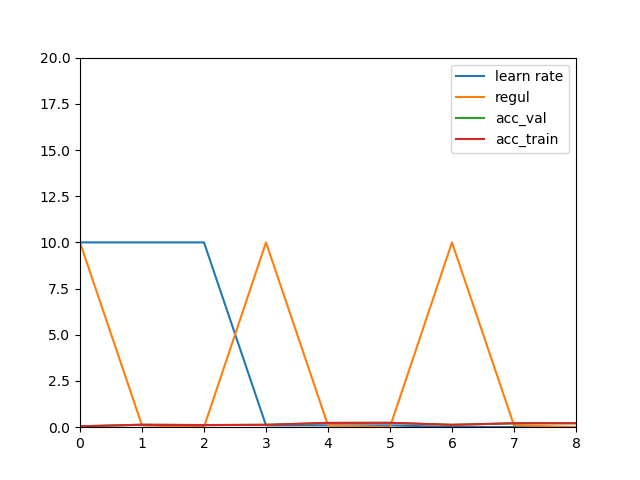

(0, 20)

In [11]:
num_epochs = 300
batch_size = 300

learning_rates = [1e1,1e-1,1e-2]
reg_strengths = [1e1,1e-1,1e-2]

best_classifier = None
best_val_accuracy = None

data:list = list()
train_val:list = list()

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
   
for l in learning_rates:
    for r in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        for i in range(0,num_epochs,10): 
            classifier.fit(train_X, train_y, epochs=10, learning_rate=l, batch_size=300, reg=r)
            pred_val = classifier.predict(val_X)
            pred_train = classifier.predict(train_X)
            accuracy_val = multiclass_accuracy(pred_val, val_y)
            accuracy_train = multiclass_accuracy(pred_train, train_y)
            train_val.append({'acc_val':accuracy_val,'acc_train':accuracy_val,'epoch':l+r})
        data.append({'learn rate':l,'regul':r,'acc_val':accuracy_val,'acc_train':accuracy_val})
        


frame = pd.DataFrame(data)
tr_val = pd.DataFrame(train_val)
print(frame)
frame.plot()
axes = plt.gca()
axes.set_ylim(0,20)

# print('best validation accuracy achieved: %f' % best_val_accuracy)

<IPython.core.display.Javascript object>


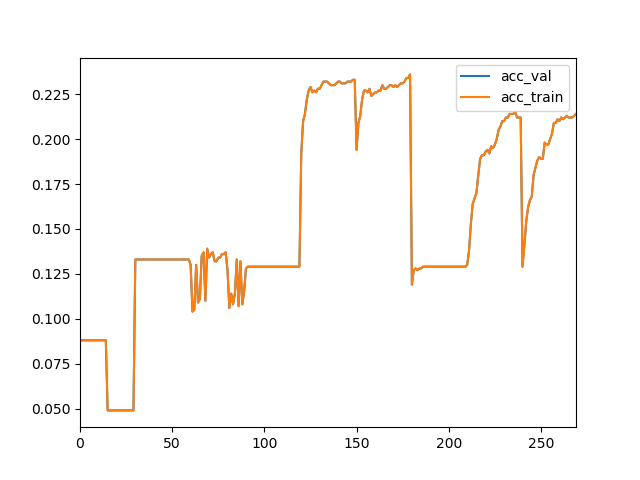

     acc_val  acc_train
0      0.088      0.088
1      0.088      0.088
2      0.088      0.088
3      0.088      0.088
4      0.088      0.088
..       ...        ...
265    0.212      0.212
266    0.212      0.212
267    0.212      0.212
268    0.213      0.213
269    0.214      0.214

[270 rows x 2 columns]


In [31]:
tr_val=pd.DataFrame(train_val)
# plt.plot(tr_val['acc_val'],color = tr_val['epoch']*100)
# plt.plot(tr_val['acc_train'])
tr_val.iloc[:,:-1].plot()
print(tr_val.iloc[:,:-1])

<IPython.core.display.Javascript object>


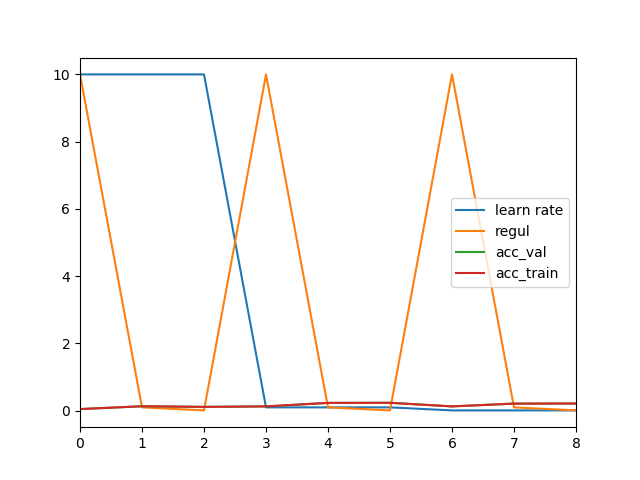

In [22]:
frame.plot()

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [20]:
print(frame)
ax=plt.subplot(projection = '3d')
ax.scatter(frame['learn rate'],frame['regul'],frame['acc_val'],c = frame['acc_val'],cmap = 'viridis')
ax.set_xlabel('learn rate')
ax.set_ylabel('regul')
ax.set_zlabel('accuracy')

   learn rate  regul  acc_val  acc_train
0       10.00  10.00    0.049      0.049
1       10.00   0.10    0.133      0.133
2       10.00   0.01    0.115      0.115
3        0.10  10.00    0.129      0.129
4        0.10   0.10    0.233      0.233
5        0.10   0.01    0.236      0.236
6        0.01  10.00    0.129      0.129
7        0.01   0.10    0.212      0.212
8        0.01   0.01    0.214      0.214


Text(0.5, 0, 'accuracy')

   learn rate  regul  acc_val  acc_train
0         0.1    0.1    0.231      0.231


TypeError: scatter() missing 1 required positional argument: 'y'

   learn rate  regul  acc_val  acc_train
0         0.1    0.1    0.231      0.231


<IPython.core.display.Javascript object>


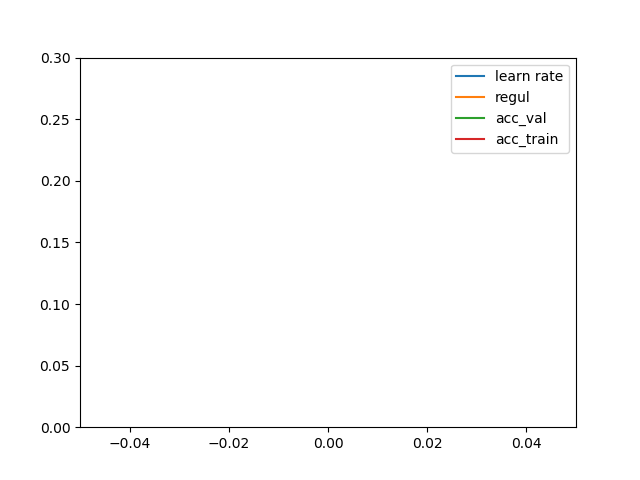

(0, 0.3)

In [56]:
print(frame)
frame.plot()
axes = plt.gca()
axes.set_ylim(0,0.3)

In [73]:
test_class = linear_classifer.LinearSoftmaxClassifier()
test_pred = test_class.pred_rand(val_X)
accuracy = multiclass_accuracy(test_pred, val_y)
print(accuracy)

0.114


# Какой же точности мы добились на тестовых данных?

In [79]:


test_pred = classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.203000


In [18]:
np.__version__

'1.17.0'